In [1]:
from time import time, sleep
from datetime import date

from requests import get
import json

from multiprocessing.pool import ThreadPool as Pool

import haversine

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

def vehicle_df_creator(vehicles):
    
    vehicles_df = pd.DataFrame(vehicles['list']).drop(['stale', 'serviceDate', 'stopSequence', 'lastUpdateTime', 'status', 'congestionLevel', 'bearing', 'capacity', 'stopDistancePercent', 'wheelchairAccessible', 'style', 'deviated'], 1)
    vehicles_df = pd.concat([vehicles_df, pd.json_normalize(vehicles_df['location'])], 1)

    vehicles_df = vehicles_df.merge(routes, left_on = 'routeId', right_on = 'id', how = 'left')
    vehicles_df = vehicles_df.merge(stops_df[['id', 'name']], left_on = 'stopId', right_on = 'id', how = 'left')

    vehicles_df.drop(['location', 'type', 'routeId', 'stopId', 'id_x', 'id_y'], 1, inplace = True)
    vehicles_df.rename(columns = {'name' : 'Megálló'}, inplace = True)

    return vehicles_df

def plot_MOL_Bubi_dist():
    
    plt.figure()
    sns.displot(data = bikes_data, x = 'bikes', color = '#89bedc', height = 4, aspect = 2, bins = 15)

    plt.title('Elérhető MOL Bubi biciklik')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

def plot_MOL_bubi():
    
    bikes_data['size_for_plot'] = bikes_data['bikes'] + 1

    fig = px.scatter_mapbox(bikes_data, lat = 'lat', lon = 'lon', hover_name = 'name', 
                            #center = {"lat": 45.444617, "lon": 12.321308}, 
                            hover_data = ['name', 'bikes'],
                            title = 'MOL Bubi bicikli-állomások és szabad biciklik száma',
                            zoom = 10.9, size_max = 12, size = 'size_for_plot', 
                            mapbox_style = 'carto-positron', width = 750)
    fig.show()

    bikes_data.drop('size_for_plot', 1, inplace = True)
    
    
def plot_STOP_TYPES():
    
    order = megallok.groupby(['type'])['id'].count().sort_values(ascending  = False)
    
    plt.figure(figsize = (9, 4))
    ax = sns.countplot(y = 'type', data = megallok, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2, order = order.index)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Megálló típusok száma')
    plt.xlabel(None)
    plt.xlim(0, 4900)
    plt.ylabel(None)
    plt.show()
    
def plot_gyujtok_map():

    fig = px.scatter_mapbox(gyujto_stop_count, lat = 'lat', lon = 'lon', hover_name = 'name', 
                            #center = {"lat": 45.444617, "lon": 12.321308}, 
                            hover_data = ['name', 'stop_count'],
                            title = 'BKK gyűjtőállomások elhelyezkedése',
                            labels = {'name' : 'Név', 'stop_count' : 'Megállók száma'},
                            zoom = 10, size_max = 15, size = 'stop_count', 
                            mapbox_style = 'carto-positron', height = 650, width = 950)
    fig.show()
    
    
def plot_stops_map():
    
    megallok['size'] = 1

    fig = px.scatter_mapbox(megallok, lat = 'lat', lon = 'lon', hover_name = 'name',
                            hover_data = ['name', 'routeIds', 'direction'],
                            title = 'BKK megállók és állomások elhelyezkedése', size = 'size', size_max = 4,
                            labels = {'name' : 'Név', 'routeIds' : 'Útvonalak', 'direction' : 'Irány'},
                            zoom = 10, mapbox_style = 'carto-positron', height = 650, width = 950)
    fig.show()
    
    megallok.drop('size', 1, inplace = True)
    
    
def plot_ROUTE_TYPES():
    
    order = routes.groupby(['type'])['id'].count().sort_values(ascending  = False)
    
    plt.figure(figsize = (9, 4))
    ax = sns.countplot(y = 'type', data = routes, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2, order = order.index)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Útvonal típusok száma')
    plt.xlabel(None)
    plt.xlim(0, 350)
    plt.ylabel(None)
    plt.show()
    
    
def plot_CELALLOMAS():
    
    plt.figure(figsize = (9, 7))
    ax = sns.barplot(y = 'name', x = 'Útvonal végállomása', data = celallomasok, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Vég- és kiinduló-állomások')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()
    
def plot_vehicles_map():
    
    vehicles_df['size'] = 1

    fig = px.scatter_mapbox(vehicles_df, lat = 'lat', lon = 'lon', hover_name = 'shortName',
                            hover_data = ['shortName', 'licensePlate', 'model', 'vehicleRouteType', 'From', 'To', 'Megálló'],
                            title = 'Aktuális járművek', size = 'size', size_max = 4.5, 
                            labels = {'label' : 'Irány', 'licensePlate' : 'Rendszám', 'shortName' : 'Jármű száma',
                                      'model' : 'Típus', 'vehicleRouteType' : 'Járműtípus'},
                            color = 'vehicleRouteType', 
                            color_discrete_map = {'BUS' : 'blue', 'TRAM' : 'yellow', 'TROLLEYBUS' : 'red', 'SUBURBAN_RAILWAY' : 'green'},
                            zoom = 10, mapbox_style = 'carto-positron', height = 700, width = 1050)
    fig.show()
    
    vehicles_df.drop('size', 1, inplace = True)
    
    
def plot_VEHICLES_TYPES():
    
    order = vehicles_df['vehicleRouteType'].value_counts()
    
    plt.figure(figsize = (9, 4))
    ax = sns.countplot(y = 'vehicleRouteType', data = vehicles_df, color = '#89bedc', edgecolor = 'black', 
                       linewidth = 1/2, order = order.index)
    
    for p in ax.patches:
        ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

    plt.title('Aktív járművek típusai')
    plt.xlabel(None)
    plt.xlim(0, vehicles_df['vehicleRouteType'].value_counts().max() + 75)
    plt.ylabel(None)
    plt.show()
    
    
def plot_BUS_TYPE(filter_type = 'ikarus'):
    
    vehicles_df_buses = vehicles_df[vehicles_df['vehicleRouteType'] == 'BUS'].copy()
    
    vehicles_df_buses[filter_type] = 0
    vehicles_df_buses.loc[vehicles_df_buses['model'].str.lower().str.contains(filter_type), filter_type] = 1
    vehicles_df_buses[filter_type] = vehicles_df_buses[filter_type].astype(str)
    
    vehicles_df_buses['size'] = 1

    fig = px.scatter_mapbox(vehicles_df_buses, lat = 'lat', lon = 'lon', hover_name = 'shortName',
                            hover_data = ['shortName', 'licensePlate', 'model', 'vehicleRouteType', 'From', 'To', 'Megálló'],
                            title = 'Busztípusok elhelyezkedése - ' + filter_type, size = 'size', size_max = 5, 
                            labels = {'label' : 'Irány', 'licensePlate' : 'Rendszám', 'shortName' : 'Jármű száma',
                                      'model' : 'Típus', 'vehicleRouteType' : 'Járműtípus'},
                            color = filter_type, 
                            color_discrete_map = {'0': 'lightgreen', '1' : 'brown'},
                            zoom = 10, mapbox_style = 'carto-positron', height = 650, width = 950)
    fig.show()
    
    vehicles_df_buses.drop('size', 1, inplace = True)
    
    
def get_trip_details(i):
    
    trip_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/trip-details.json?tripId=' + i + '&date=' + today + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch
    trip_data = get(trip_link, headers = headers).json()
    
    if 'data' in trip_data.keys():
        trip_data = trip_data['data']
        
        trip_id = i
    
        if 'vehicle' in trip_data['entry'].keys():
            route_id = trip_data['entry']['vehicle']['routeId']    
        else:
            route_id = np.nan

        if 'stopSequence' in trip_data['entry']['stopTimes'][-1].keys():
            stops_num = trip_data['entry']['stopTimes'][-1]['stopSequence']
        else:
            stops_num = np.nan

        if 'shapeDistTraveled' in trip_data['entry']['stopTimes'][-1].keys():
            dist = trip_data['entry']['stopTimes'][-1]['shapeDistTraveled']
        else:
            dist = np.nan

        trip_dict = {'id' : route_id, 'tripId' : trip_id, 'num_of_stops' : stops_num, 'total_distance' : dist}

        return trip_dict
    
    else:
        pass 
    
    
BOXPLOT_PROPS = {
    'boxprops':{'edgecolor':'black', 'linewidth' : 1},
    'flierprops':{'markerfacecolor':'black', 'markeredgecolor':'darkgray', 'marker' : 'x'},
    'medianprops':{'color':'black', 'linewidth' : 1},
    'whiskerprops':{'color':'black', 'linewidth' : 1},
    'capprops':{'color':'black', 'linewidth' : 1}
}

def boxplot_sns(data, x, y):  
    
    order = data.groupby([x]).median().sort_values(y, ascending = False)

    plt.figure(figsize = (8, 4))
    sns.boxplot(data = data, y = x, x = y, color = 'blue', fliersize = 2, 
                **BOXPLOT_PROPS, order = order.index)
    plt.xlabel(y)
    plt.ylabel(None)
    plt.title('Járműtípusonkénti eloszlások\n')
    plt.show()

In [2]:
%%time

headers = {'User-agent' : 'Mozilla/5.0 (Windows; U; Windows NT 5.1; de; rv:1.9.1.5) Gecko/20091102 Firefox/3.5.5'}

time_epoch = str(int(time()))
today = date.today().strftime("%Y%m%d")
lat = str(47.497913)
lon = str(19.040236)

vehicles_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/vehicles-for-location.json?ifModifiedSince=' + time_epoch + '&lat=' + lat + '&latSpan=1&lon=' + lon + '&lonSpan=1&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
stops_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/stops-for-location.json?lat=' + lat + '&latSpan=1&lon=' + lon + '&lonSpan=1&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
bikes_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/bicycle-rental.json?key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'

stops = get(stops_link, headers = headers).json()['data']
bikes = get(bikes_link, headers = headers).json()['data']
sleep(1)
vehicles = get(vehicles_link, headers = headers).json()['data']

Wall time: 2.2 s


### Bikes

In [3]:
bikes_data = pd.DataFrame(bikes['list'])
bikes_data.drop(['type', 'spaces'], 1, inplace = True)

<Figure size 432x288 with 0 Axes>

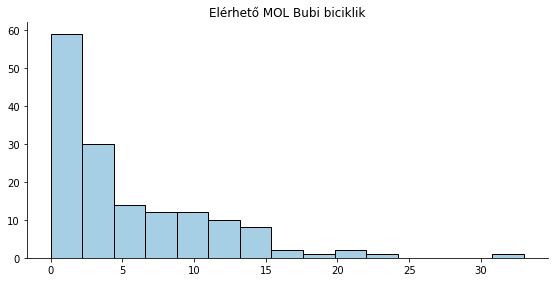

In [4]:
plot_MOL_Bubi_dist()

In [5]:
plot_MOL_bubi()

### Stops

In [6]:
stops_df = pd.DataFrame.from_dict(stops['references']['stops'], orient = 'index').reset_index(drop = True)
stops_df.drop(['description', 'style', 'wheelchairBoarding'], 1, inplace = True)
stops_df.head(3)

,id,lat,lon,name,code,direction,locationType,locationSubType,routeIds,stopColorType,parentStationId,type
0,BKK_CSF00232,47.513817,19.033945,Margit körút,CSF00232,,1,stop-area,[],OTHER,NaN,NaN
1,BKK_CSF00233,47.514609,19.033215,Apostol utca,CSF00233,,1,stop-area,[],OTHER,NaN,NaN
2,BKK_CSF01563,47.483975,19.117162,Egészségház,CSF01563,,1,stop-area,[],OTHER,NaN,NaN


In [7]:
gyujtok = stops_df[(stops_df['type'].isnull()) & 
                   (stops_df['stopColorType'] == 'OTHER') & 
                   (stops_df['locationSubType'].isin(['station', 'stop-area']))].copy()

In [8]:
megallok = stops_df[(stops_df['type'].notnull())].copy()
megallok.drop(['locationType', 'locationSubType'], 1, inplace = True)

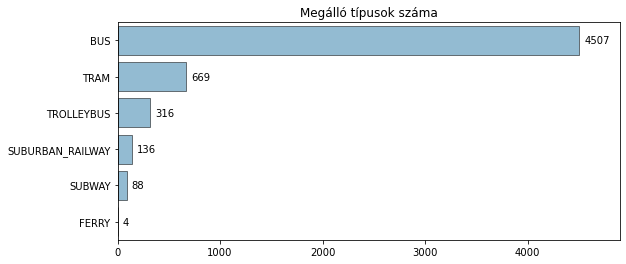

In [9]:
plot_STOP_TYPES()

In [10]:
gyujto_stop_count = megallok.groupby('parentStationId')['id'].count().reset_index().rename(columns = {'id' : 'stop_count'})
gyujto_stop_count = gyujtok[['id', 'lat', 'lon', 'name']].merge(gyujto_stop_count, left_on = 'id', right_on = 'parentStationId').drop('parentStationId', 1)

In [11]:
plot_gyujtok_map()

In [ ]:
plot_stops_map()

Calculate distance matrix - find farthest from all stop, closest stops, etc... For this use the 'Gyujok' data, not the actual stops

In [ ]:
%%time

distances = []

for i, row_i in gyujtok[gyujtok['id'].str.contains('CS')].iterrows():
    
    _from_id = row_i['id']
    _from_name = row_i['name']
    _from_coord = (row_i['lat'], row_i['lon'])
    
    for j, row_j in gyujtok[gyujtok['id'].str.contains('CS')].iterrows():
        
        _to_id = row_j['id']
        _to_name = row_j['name']
        _to_coord = (row_j['lat'], row_j['lon'])

        _dist = haversine.haversine(_from_coord, _to_coord, unit = haversine.Unit.METERS)

        _dist_dict = {'from_id' : _from_id, 'to_id' : _to_id,
                      'from_name' : _from_name,  'to_name' : _to_name, 'distance' : _dist}
        distances.append(_dist_dict)

In [ ]:
%%time

distances_df = pd.DataFrame(distances)
distances_df = distances_df[distances_df['distance'] != 0]
# distances.drop_duplicates('distance', inplace = True)

In [ ]:
# distances_df.sort_values('distance', ascending = False)

10 most farthest away from each other stops

In [ ]:
farthest = distances_df.groupby('from_id')['distance'].min().sort_values().tail(10)

In [ ]:
farthes_df = distances_df[(distances_df['from_id'].isin(farthest.index) )& 
                          (distances_df['distance'].isin(farthest.values))]

farthes_df = farthes_df.drop_duplicates('from_name')
farthes_df = farthes_df.drop_duplicates('distance')
farthes_df.sort_values('distance', ascending = False)

Farthest away stops:

    - Monor - Vecsés: 13km
    - Ráckeve - Angyalisziget: 2.7km

### Routes

In [12]:
routes = pd.DataFrame.from_dict(stops['references']['routes'], orient = 'index')\
                     .reset_index(drop = True)\
                     .drop(['color', 'textColor', 'agencyId', 'iconDisplayType', 'iconDisplayText', 'style', 'sortOrder', 'bikesAllowed'], 1)

# potlok = routes[routes['id'].str.contains('VP|HP|MP')]
# potlok kiszurese
# routes = routes[~routes['id'].str.contains('VP|HP|MP')]

routes[['From', 'To']] = routes['description'].str.split('|', expand = True)

routes['To'] = routes['To'].str.strip()
routes['From'] = routes['From'].str.strip()

routes.drop(['description'], 1, inplace = True)

routes.head(3)

,id,shortName,type,From,To
0,BKK_9960,996,BUS,Cinkotai autóbuszgarázs,Újpest-központ M
1,BKK_9720,972,BUS,"Törökbálint, Nyár utca",Móricz Zs. körtér M
2,BKK_9961,996A,BUS,Cinkotai autóbuszgarázs,Újpest-központ M


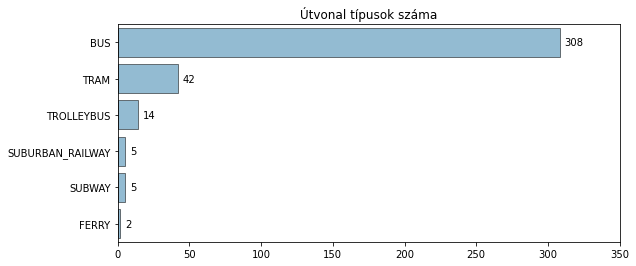

In [13]:
plot_ROUTE_TYPES()

In [14]:
celallomasok = pd.concat([routes['From'], routes['To']]).value_counts().reset_index().rename(columns = {'index' : 'name', 0 : 'Útvonal végállomása'}).head(25)
#celallomasok = stops_df[['name', 'lat', 'lon']].copy().drop_duplicates('name').merge(celallomasok, how = 'right')

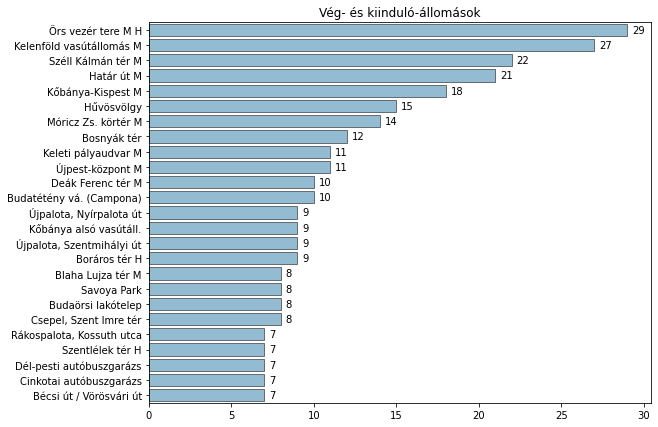

In [15]:
plot_CELALLOMAS()

### Vehicles - currently active on Map

In [16]:
vehicles_df = vehicle_df_creator(vehicles)
vehicles_df.head(3)

,vehicleId,licensePlate,label,model,vehicleRouteType,tripId,lat,lon,shortName,From,To,Megálló
0,BKK_4510,V1440,Deák Ferenc tér M,Ganz csuklós,TRAM,BKK_C22292792,47.439620,19.036217,47,Városház tér,Deák Ferenc tér M,Budafok kocsiszín
1,BKK_5840,V2112,Bécsi út / Vörösvári út,CAF 9 modulos szerelvény,TRAM,BKK_C3288532683,47.467937,19.050058,1,Kelenföld vasútállomás M,Bécsi út / Vörösvári út,Budafoki út / Dombóvári út
2,BKK_3663,LOV871,Boráros tér H,VanHool AG318 csuklós autóbusz,BUS,BKK_C37312292,47.479626,19.067080,23E,Boráros tér H,Pesterzsébeti lakótelep,NaN


In [17]:
print('Aktív járművek:', vehicles_df.shape[0])

Aktív járművek: 1600


In [18]:
for i in vehicles_df['vehicleRouteType'].unique():
    print(i, '- Modellek\n')
    print(vehicles_df[vehicles_df['vehicleRouteType'] == i]['model'].value_counts())
    print('\n')

TRAM - Modellek

Tátra T5C5K                  68
TW 6000                      41
CAF 5 modulos szerelvény     40
Siemens Combino              34
Ganz csuklós                 24
KCSV7 Korszerűsített Ganz    21
CAF 9 modulos szerelvény     14
Tátra T5C5                    4
Name: model, dtype: int64


BUS - Modellek

MERCEDES Conecto csuklós                    164
MAN Lions City A21 (ArrivaBus)              118
Volvo 7700A típusú csuklós autóbusz         113
MB Citaro C2-S1-G csuklós autóbusz           70
MB Citaro C2-S1 szóló autóbusz               67
MERCEDES Citaro O 530 (BKV spec.)            65
MERCEDES Conecto szóló (BKV)                 64
MAN A21 szóló (Volán, helyi, 3 ajtós)        53
Volvo szóló autóbusz                         49
MERCEDES Conecto 2 szóló autóbusz            43
VanHool A330 CNG típusú szóló autóbusz       35
Ikarus 280-as típusú autóbusz                35
MERCEDES Conecto G 2 csuklós autóbusz        35
VanHool  NewAG300 csuklós autóbusz           33
MERCEDES O5

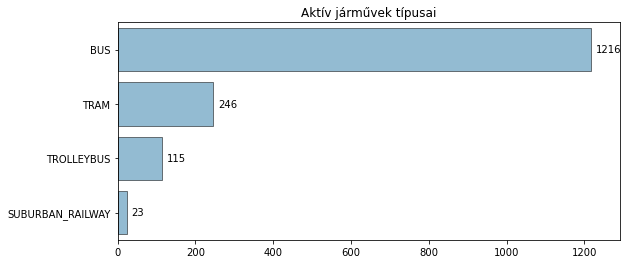

In [19]:
plot_VEHICLES_TYPES()

In [20]:
plot_vehicles_map()

In [26]:
plot_BUS_TYPE('man')

### Trips - so fat can only scrape active trips - worth re running the Vehicle script before

In [27]:
%%time

time_epoch = str(int(time()))
today = date.today().strftime("%Y%m%d")

vehicles_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/vehicles-for-location.json?ifModifiedSince=' + time_epoch + '&lat=' + lat + '&latSpan=1&lon=' + lon + '&lonSpan=1&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
sleep(2)
vehicles = get(vehicles_link, headers = headers).json()['data']

vehicles_rerun = vehicle_df_creator(vehicles)

trips_list = vehicles_rerun.drop_duplicates(['vehicleRouteType', 'shortName', 'From', 'To'])['tripId'].unique().tolist()
trips_list = [i for i in trips_list if isinstance(i, float) == False]
len(trips_list)

Wall time: 2.35 s


258

In [28]:
%%time

trip_dicts = []

pool = Pool(4)

for i in trips_list:
    pool.apply_async(get_trip_details, (i,), callback = trip_dicts.append)

pool.close()
pool.join()

Wall time: 10.1 s


In [29]:
trips_df = pd.DataFrame([i for i in trip_dicts if i is not None])
trips_df.dropna(inplace = True)
print(trips_df.shape)

(256, 4)


In [30]:
trips_df = trips_df.merge(routes)
trips_df.head(3)

,id,tripId,num_of_stops,total_distance,shortName,type,From,To
0,BKK_3470,BKK_C22292792,20,8784.0,47,TRAM,Városház tér,Deák Ferenc tér M
1,BKK_3010,BKK_C3288532683,31,18124.0,1,TRAM,Kelenföld vasútállomás M,Bécsi út / Vörösvári út
2,BKK_1685,BKK_C364072680,21,14360.0,168E,BUS,"Rákoshegy, Ferihegyi út",Örs vezér tere M H


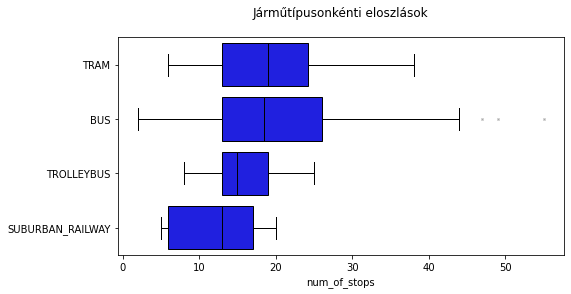

In [31]:
boxplot_sns(trips_df, 'type', 'num_of_stops')

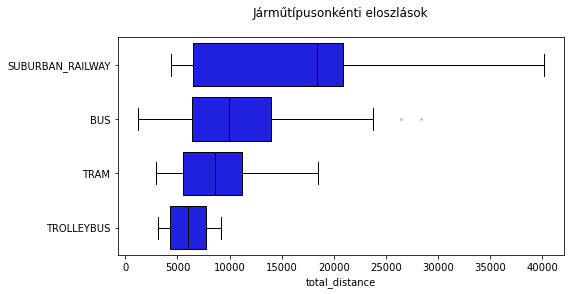

In [32]:
boxplot_sns(trips_df, 'type', 'total_distance')

Legkevesebb megálló

In [33]:
trips_df[trips_df['num_of_stops'] < 5].sort_values('num_of_stops', ascending = True)

,id,tripId,num_of_stops,total_distance,shortName,type,From,To
53,BKK_1005,BKK_C38696558,2,20789.0,100E,BUS,Liszt Ferenc Airport 2,Deák Ferenc tér M
178,BKK_MP51,BKK_C38215929,3,1205.0,M1,BUS,Deák Ferenc tér M,Mexikói út M
58,BKK_VP60,BKK_C37091250,4,1316.0,60,BUS,Széchenyi-hegy,Svábhegy
124,BKK_1650,BKK_C37708186,4,1412.0,165,BUS,Remetehegyi út,Kolosy tér
232,BKK_2360,BKK_C37353145,4,2514.0,236,BUS,Havanna utcai lakótelep,Market Central Ferihegy


Legtöbb megálló

In [34]:
trips_df[trips_df['num_of_stops'] > 40].sort_values('num_of_stops', ascending = False)

,id,tripId,num_of_stops,total_distance,shortName,type,From,To
193,BKK_0880,BKK_C27177361,55,28321.0,88,BUS,Budatétény vá. (Campona),Kelenföld vasútállomás M
121,BKK_1980,BKK_C32643648,49,20254.0,198,BUS,"R.csaba-Újtelep, Tóalmás u.",Dél-pesti autóbuszgarázs
185,BKK_0460,BKK_C316531108,47,23722.0,46,BUS,Helikopter lakópark,"Újpalota, Nyírpalota út"
123,BKK_0050,BKK_C35669444,44,18928.0,5,BUS,"Rákospalota, Kossuth utca",Pasaréti tér
46,BKK_0360,BKK_C38699844,43,19508.0,36,BUS,"Csepel, Csillagtelep",Pestszentlőrinc vasútáll.
16,BKK_0085,BKK_C371251482,41,20650.0,8E,BUS,"Újpalota, Nyírpalota út",Kelenföld vasútállomás M
150,BKK_2960,BKK_B94521324,41,22820.0,296,BUS,"B.megyer, Újmegyeri tér","Újpalota, Szentmihályi út"
194,BKK_1400,BKK_C35444245,41,23205.0,140,BUS,"Törökbálint, bevásárlóközp.",Széll Kálmán tér M


Legkisebb távolság

In [35]:
trips_df[trips_df['total_distance'] < 2000].sort_values('total_distance', ascending = True)

,id,tripId,num_of_stops,total_distance,shortName,type,From,To
178,BKK_MP51,BKK_C38215929,3,1205.0,M1,BUS,Deák Ferenc tér M,Mexikói út M
58,BKK_VP60,BKK_C37091250,4,1316.0,60,BUS,Széchenyi-hegy,Svábhegy
124,BKK_1650,BKK_C37708186,4,1412.0,165,BUS,Remetehegyi út,Kolosy tér
55,BKK_0161,BKK_C382077509,5,1417.0,16A,BUS,Dísz tér,Széll Kálmán tér M
207,BKK_0710,BKK_C350531972,5,1482.0,71,BUS,Szentmiklósi út,Szent Imre tér


Legnagyobb távolság

In [36]:
trips_df[trips_df['total_distance'] > 20000].sort_values('total_distance', ascending = False)

,id,tripId,num_of_stops,total_distance,shortName,type,From,To
49,BKK_H6,BKK_H200111_386,20,40115.0,H6,SUBURBAN_RAILWAY,Ráckeve,Közvágóhíd
193,BKK_0880,BKK_C27177361,55,28321.0,88,BUS,Budatétény vá. (Campona),Kelenföld vasútállomás M
52,BKK_1335,BKK_C38613799,38,26427.0,133E,BUS,"Újpalota, Nyírpalota út","Nagytétény, Erdélyi utca"
185,BKK_0460,BKK_C316531108,47,23722.0,46,BUS,Helikopter lakópark,"Újpalota, Nyírpalota út"
194,BKK_1400,BKK_C35444245,41,23205.0,140,BUS,"Törökbálint, bevásárlóközp.",Széll Kálmán tér M
179,BKK_2240,BKK_C3441121,36,23144.0,224,BUS,"Újpalota, Szentmihályi út","Újpalota, Szentmihályi út"
150,BKK_2960,BKK_B94521324,41,22820.0,296,BUS,"B.megyer, Újmegyeri tér","Újpalota, Szentmihályi út"
115,BKK_0380,BKK_C38483555,35,20842.0,38,BUS,Szigetszentmiklós,"Csepel, Szent Imre tér"
31,BKK_1620,BKK_C321832582,39,20841.0,162,BUS,"Maglód, Auchan áruház",Kőbánya alsó vasútáll.
25,BKK_H5,BKK_H41163_4,17,20829.0,H5,SUBURBAN_RAILWAY,Szentendre,Batthyány tér


In [ ]:
# vehicles_df[vehicles_df['tripId'] == 'BKK_C175521046']

In [ ]:
# trip_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/trip-details.json?tripId=' + 'BKK_1634051485889' + '&date=' + today + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch
# get(trip_link, headers = headers).json()

### Stop - todo

In [ ]:
stop_id = 'BKK_F03326' # 45, Anilin --> Ors

stop_schedule_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/schedule-for-stop.json?stopId=' + stop_id + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch
stop_vehicle_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/vehicles-for-stop.json?stopId=' + stop_id + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
stop_route_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/route-details-for-stop.json?stopId=' + stop_id + '&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b'
stop_arrivals_departures_link = 'https://futar.bkk.hu/api/query/v1/ws/otp/api/where/arrivals-and-departures-for-stop.json?includeReferences=agencies,routes,trips,stops&stopId=' + stop_id + '&minutesBefore=1&minutesAfter=30&key=bkk-web&version=4&appVersion=3.13.1-59506-4e2e9a7b&_=' + time_epoch


In [ ]:
# stop_schedule = get(stop_schedule_link, headers = headers).json()['data']
# [{i['routeId'] : i['directions'][0]['stopTimes']} for i in stop_schedule['entry']['schedules']]

In [ ]:
# pd.DataFrame(get(stop_vehicle_link, headers = headers).json()['data']['list'])

In [ ]:
# pd.DataFrame(get(stop_route_link, headers = headers).json()['data']['list']) # NOT NEEDED

In [ ]:
# get(stop_arrivals_departures_link, headers = headers).json()['data']['references']['trips']